In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!ls

drive  sample_data


### Import libs

In [0]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from sklearn.metrics import average_precision_score

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.objectives import categorical_crossentropy

from keras.models import Model
from keras.utils import generic_utils
from keras.engine import Layer, InputSpec
from keras import initializers, regularizers

#### Config setting

In [0]:
class Config:

	def __init__(self):

		# Print the process or not
		self.verbose = True

		# Name of base network
		self.network = 'vgg'

		# Setting for data augmentation
		self.use_horizontal_flips = False
		self.use_vertical_flips = False
		self.rot_90 = False

		# Anchor box scales
    # Note that if im_size is smaller, anchor_box_scales should be scaled
    # Original anchor_box_scales in the paper is [128, 256, 512]
		self.anchor_box_scales = [64, 128, 256] 

		# Anchor box ratios
		self.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]

		# Size to resize the smallest side of the image
		# Original setting in paper is 600. Set to 300 in here to save training time
		self.im_size = 300

		# image channel-wise mean to subtract
		self.img_channel_mean = [103.939, 116.779, 123.68]
		self.img_scaling_factor = 1.0

		# number of ROIs at once
		self.num_rois = 4

		# stride at the RPN (this depends on the network configuration)
		self.rpn_stride = 16

		self.balanced_classes = False

		# scaling the stdev
		self.std_scaling = 4.0
		self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

		# overlaps for RPN
		self.rpn_min_overlap = 0.3
		self.rpn_max_overlap = 0.7

		# overlaps for classifier ROIs
		self.classifier_min_overlap = 0.1
		self.classifier_max_overlap = 0.5

		# placeholder for the class mapping, automatically generated by the parser
		self.class_mapping = None

		self.model_path = None

#### Parser the data from annotation file

In [0]:
def get_data(input_path):
	"""Parser the data from annotation file
	
	Args:
		input_path: annotation file path

	Returns:
		all_data: list(filepath, width, height, list(bboxes))
		classes_count: dict{key:class_name, value:count_num} 
			e.g. {'Car': 2383, 'Mobile phone': 1108, 'Person': 3745}
		class_mapping: dict{key:class_name, value: idx}
			e.g. {'Car': 0, 'Mobile phone': 1, 'Person': 2}
	"""
	found_bg = False
	all_imgs = {}

	classes_count = {}

	class_mapping = {}

	visualise = True

	i = 0
	
	with open(input_path,'r') as f:

		print('Parsing annotation files')

		for line in f:
			if i==0:
				i+=1
				continue

			# Print process
			sys.stdout.write('\r'+'idx=' + str(i))
			i += 1

			line_split = line.strip().split(',')

			# Make sure the info saved in annotation file matching the format (path_filename, x1, y1, x2, y2, class_name)
			# Note:
			#	One path_filename might has several classes (class_name)
			#	x1, y1, x2, y2 are the pixel value of the origial image, not the ratio value
			#	(x1, y1) top left coordinates; (x2, y2) bottom right coordinates
			#   x1,y1-------------------
			#	|						|
			#	|						|
			#	|						|
			#	|						|
			#	---------------------x2,y2

			(filename,x1,y1,x2,y2,class_name) = line_split

			if class_name not in classes_count:
				classes_count[class_name] = 1
			else:
				classes_count[class_name] += 1

			if class_name not in class_mapping:
				if class_name == 'bg' and found_bg == False:
					print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
					found_bg = True
				class_mapping[class_name] = len(class_mapping)

			if filename not in all_imgs:
				all_imgs[filename] = {}
				
				img = cv2.imread(filename)
				(rows,cols) = img.shape[:2]
				all_imgs[filename]['filepath'] = filename
				all_imgs[filename]['width'] = cols
				all_imgs[filename]['height'] = rows
				all_imgs[filename]['bboxes'] = []
				# if np.random.randint(0,6) > 0:
				# 	all_imgs[filename]['imageset'] = 'trainval'
				# else:
				# 	all_imgs[filename]['imageset'] = 'test'

			all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})


		all_data = []
		for key in all_imgs:
			all_data.append(all_imgs[key])
		
		# make sure the bg class is last in the list
		if found_bg:
			if class_mapping['bg'] != len(class_mapping) - 1:
				key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping)-1][0]
				val_to_switch = class_mapping['bg']
				class_mapping['bg'] = len(class_mapping) - 1
				class_mapping[key_to_switch] = val_to_switch
		
		return all_data, classes_count, class_mapping

#### Define ROI Pooling Convolutional Layer

In [0]:
class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, rows, cols, channels)`
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):

        self.dim_ordering = K.image_data_format()
        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]   

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        # x[0] is image with shape (rows, cols, channels)
        img = x[0]

        # x[1] is roi with shape (num_rois,4) with ordering (x,y,w,h)
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            # Resized roi of the image to pooling size (7x7)
            rs = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)
                

        final_output = K.concatenate(outputs, axis=0)

        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels)
        # Might be (1, 4, 7, 7, 3)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        # permute_dimensions is similar to transpose
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    
    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

#### Vgg-16 model

In [0]:
def get_img_output_length(width, height):
    def get_output_length(input_length):
        return input_length//16

    return get_output_length(width), get_output_length(height)    

def nn_base(input_tensor=None, trainable=False):


    input_shape = (None, None, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    # x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    return x

####  RPN layer

In [0]:
def rpn_layer(base_layers, num_anchors):
    """Create a rpn layer
        Step1: Pass through the feature map from base layer to a 3x3 512 channels convolutional layer
                Keep the padding 'same' to preserve the feature map's size
        Step2: Pass the step1 to two (1,1) convolutional layer to replace the fully connected layer
                classification layer: num_anchors (9 in here) channels for 0, 1 sigmoid activation output
                regression layer: num_anchors*4 (36 in here) channels for computing the regression of bboxes with linear activation
    Args:
        base_layers: vgg in here
        num_anchors: 9 in here

    Returns:
        [x_class, x_regr, base_layers]
        x_class: classification for whether it's an object
        x_regr: bboxes regression
        base_layers: vgg in here
    """
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]

####  Classifier layer

In [0]:
def classifier_layer(base_layers, input_rois, num_rois, nb_classes = 4):
    """Create a classifier layer
    
    Args:
        base_layers: vgg
        input_rois: `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
        num_rois: number of rois to be processed in one time (4 in here)

    Returns:
        list(out_class, out_regr)
        out_class: classifier layer output
        out_regr: regression layer output
    """

    input_shape = (num_rois,7,7,512)

    pooling_regions = 7

    # out_roi_pool.shape = (1, num_rois, channels, pool_size, pool_size)
    # num_rois (4) 7x7 roi pooling
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    # Flatten the convlutional layer and connected to 2 FC and 2 dropout
    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.2))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.2))(out)

    # There are two output layer
    # out_class: softmax acivation function for classify the class name of the object
    # out_regr: linear activation function for bboxes coordinates regression
    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]

#### Calculate IoU (Intersection of Union)

In [0]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):
	# a and b should be (x1,y1,x2,y2)

	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

#### Calculate the rpn for all anchors of all images

In [0]:
def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):
	"""(Important part!) Calculate the rpn for all anchors 
		If feature map has shape 38x50=1900, there are 1900x9=17100 potential anchors
	
	Args:
		C: config
		img_data: augmented image data
		width: original image width (e.g. 600)
		height: original image height (e.g. 800)
		resized_width: resized image width according to C.im_size (e.g. 300)
		resized_height: resized image height according to C.im_size (e.g. 400)
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size

	Returns:
		y_rpn_cls: list(num_bboxes, y_is_box_valid + y_rpn_overlap)
			y_is_box_valid: 0 or 1 (0 means the box is invalid, 1 means the box is valid)
			y_rpn_overlap: 0 or 1 (0 means the box is not an object, 1 means the box is an object)
		y_rpn_regr: list(num_bboxes, 4*y_rpn_overlap + y_rpn_regr)
			y_rpn_regr: x1,y1,x2,y2 bunding boxes coordinates
	"""
	downscale = float(C.rpn_stride) 
	anchor_sizes = C.anchor_box_scales   # 128, 256, 512
	anchor_ratios = C.anchor_box_ratios  # 1:1, 1:2*sqrt(2), 2*sqrt(2):1
	num_anchors = len(anchor_sizes) * len(anchor_ratios) # 3x3=9

	# calculate the output map size based on the network architecture
	(output_width, output_height) = img_length_calc_function(resized_width, resized_height)

	n_anchratios = len(anchor_ratios)    # 3
	
	# initialise empty output objectives
	y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
	y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
	y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))

	num_bboxes = len(img_data['bboxes'])

	num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
	best_anchor_for_bbox = -1*np.ones((num_bboxes, 4)).astype(int)
	best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
	best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
	best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

	# get the GT box coordinates, and resize to account for image resizing
	gta = np.zeros((num_bboxes, 4))
	for bbox_num, bbox in enumerate(img_data['bboxes']):
		# get the GT box coordinates, and resize to account for image resizing
		gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
		gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
		gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
		gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))
	
	# rpn ground truth

	for anchor_size_idx in range(len(anchor_sizes)):
		for anchor_ratio_idx in range(n_anchratios):
			anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
			anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]	
			
			for ix in range(output_width):					
				# x-coordinates of the current anchor box	
				x1_anc = downscale * (ix + 0.5) - anchor_x / 2
				x2_anc = downscale * (ix + 0.5) + anchor_x / 2	
				
				# ignore boxes that go across image boundaries					
				if x1_anc < 0 or x2_anc > resized_width:
					continue
					
				for jy in range(output_height):

					# y-coordinates of the current anchor box
					y1_anc = downscale * (jy + 0.5) - anchor_y / 2
					y2_anc = downscale * (jy + 0.5) + anchor_y / 2

					# ignore boxes that go across image boundaries
					if y1_anc < 0 or y2_anc > resized_height:
						continue

					# bbox_type indicates whether an anchor should be a target
					# Initialize with 'negative'
					bbox_type = 'neg'

					# this is the best IOU for the (x,y) coord and the current anchor
					# note that this is different from the best IOU for a GT bbox
					best_iou_for_loc = 0.0

					for bbox_num in range(num_bboxes):
						
						# get IOU of the current GT box and the current anchor box
						curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
						# calculate the regression targets if they will be needed
						if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > C.rpn_max_overlap:
							cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
							cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
							cxa = (x1_anc + x2_anc)/2.0
							cya = (y1_anc + y2_anc)/2.0

							# x,y are the center point of ground-truth bbox
							# xa,ya are the center point of anchor bbox (xa=downscale * (ix + 0.5); ya=downscale * (iy+0.5))
							# w,h are the width and height of ground-truth bbox
							# wa,ha are the width and height of anchor bboxe
							# tx = (x - xa) / wa
							# ty = (y - ya) / ha
							# tw = log(w / wa)
							# th = log(h / ha)
							tx = (cx - cxa) / (x2_anc - x1_anc)
							ty = (cy - cya) / (y2_anc - y1_anc)
							tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
							th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))
						
						if img_data['bboxes'][bbox_num]['class'] != 'bg':

							# all GT boxes should be mapped to an anchor box, so we keep track of which anchor box was best
							if curr_iou > best_iou_for_bbox[bbox_num]:
								best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
								best_iou_for_bbox[bbox_num] = curr_iou
								best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
								best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]

							# we set the anchor to positive if the IOU is >0.7 (it does not matter if there was another better box, it just indicates overlap)
							if curr_iou > C.rpn_max_overlap:
								bbox_type = 'pos'
								num_anchors_for_bbox[bbox_num] += 1
								# we update the regression layer target if this IOU is the best for the current (x,y) and anchor position
								if curr_iou > best_iou_for_loc:
									best_iou_for_loc = curr_iou
									best_regr = (tx, ty, tw, th)

							# if the IOU is >0.3 and <0.7, it is ambiguous and no included in the objective
							if C.rpn_min_overlap < curr_iou < C.rpn_max_overlap:
								# gray zone between neg and pos
								if bbox_type != 'pos':
									bbox_type = 'neutral'

					# turn on or off outputs depending on IOUs
					if bbox_type == 'neg':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'neutral':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'pos':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						start = 4 * (anchor_ratio_idx + n_anchratios * anchor_size_idx)
						y_rpn_regr[jy, ix, start:start+4] = best_regr

	# we ensure that every bbox has at least one positive RPN region

	for idx in range(num_anchors_for_bbox.shape[0]):
		if num_anchors_for_bbox[idx] == 0:
			# no box with an IOU greater than zero ...
			if best_anchor_for_bbox[idx, 0] == -1:
				continue
			y_is_box_valid[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			y_rpn_overlap[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			start = 4 * (best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3])
			y_rpn_regr[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]

	y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
	y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

	y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
	y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

	y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
	y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

	pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
	neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

	num_pos = len(pos_locs[0])

	# one issue is that the RPN has many more negative than positive regions, so we turn off some of the negative
	# regions. We also limit it to 256 regions.
	num_regions = 256

	if len(pos_locs[0]) > num_regions/2:
		val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
		y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
		num_pos = num_regions/2

	if len(neg_locs[0]) + num_pos > num_regions:
		val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
		y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

	y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
	y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

	return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos

#### Get new image size and augment the image

In [0]:
def get_new_img_size(width, height, img_min_side=300):
	if width <= height:
		f = float(img_min_side) / width
		resized_height = int(f * height)
		resized_width = img_min_side
	else:
		f = float(img_min_side) / height
		resized_width = int(f * width)
		resized_height = img_min_side

	return resized_width, resized_height

def augment(img_data, config, augment=True):
	assert 'filepath' in img_data
	assert 'bboxes' in img_data
	assert 'width' in img_data
	assert 'height' in img_data

	img_data_aug = copy.deepcopy(img_data)

	img = cv2.imread(img_data_aug['filepath'])

	if augment:
		rows, cols = img.shape[:2]

		if config.use_horizontal_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 1)
			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				bbox['x2'] = cols - x1
				bbox['x1'] = cols - x2

		if config.use_vertical_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 0)
			for bbox in img_data_aug['bboxes']:
				y1 = bbox['y1']
				y2 = bbox['y2']
				bbox['y2'] = rows - y1
				bbox['y1'] = rows - y2

		if config.rot_90:
			angle = np.random.choice([0,90,180,270],1)[0]
			if angle == 270:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 0)
			elif angle == 180:
				img = cv2.flip(img, -1)
			elif angle == 90:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 1)
			elif angle == 0:
				pass

			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				y1 = bbox['y1']
				y2 = bbox['y2']
				if angle == 270:
					bbox['x1'] = y1
					bbox['x2'] = y2
					bbox['y1'] = cols - x2
					bbox['y2'] = cols - x1
				elif angle == 180:
					bbox['x2'] = cols - x1
					bbox['x1'] = cols - x2
					bbox['y2'] = rows - y1
					bbox['y1'] = rows - y2
				elif angle == 90:
					bbox['x1'] = rows - y2
					bbox['x2'] = rows - y1
					bbox['y1'] = x1
					bbox['y2'] = x2        
				elif angle == 0:
					pass

	img_data_aug['width'] = img.shape[1]
	img_data_aug['height'] = img.shape[0]
	return img_data_aug, img

#### Generate the ground_truth anchors

In [0]:
def get_anchor_gt(all_img_data, C, img_length_calc_function, mode='train'):
	""" Yield the ground-truth anchors as Y (labels)
		
	Args:
		all_img_data: list(filepath, width, height, list(bboxes))
		C: config
		img_length_calc_function: function to calculate final layer's feature map (of base model) size according to input image size
		mode: 'train' or 'test'; 'train' mode need augmentation

	Returns:
		x_img: image data after resized and scaling (smallest size = 300px)
		Y: [y_rpn_cls, y_rpn_regr]
		img_data_aug: augmented image data (original image with augmentation)
		debug_img: show image for debug
		num_pos: show number of positive anchors for debug
	"""
	while True:

		for img_data in all_img_data:
			try:

				# read in image, and optionally add augmentation

				if mode == 'train':
					img_data_aug, x_img = augment(img_data, C, augment=True)
				else:
					img_data_aug, x_img = augment(img_data, C, augment=False)

				(width, height) = (img_data_aug['width'], img_data_aug['height'])
				(rows, cols, _) = x_img.shape

				assert cols == width
				assert rows == height

				# get image dimensions for resizing
				(resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

				# resize the image so that smalles side is length = 300px
				x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
				debug_img = x_img.copy()

				try:
					y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(C, img_data_aug, width, height, resized_width, resized_height, img_length_calc_function)
				except:
					continue

				# Zero-center by mean pixel, and preprocess image

				x_img = x_img[:,:, (2, 1, 0)]  # BGR -> RGB
				x_img = x_img.astype(np.float32)
				x_img[:, :, 0] -= C.img_channel_mean[0]
				x_img[:, :, 1] -= C.img_channel_mean[1]
				x_img[:, :, 2] -= C.img_channel_mean[2]
				x_img /= C.img_scaling_factor

				x_img = np.transpose(x_img, (2, 0, 1))
				x_img = np.expand_dims(x_img, axis=0)

				y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= C.std_scaling

				x_img = np.transpose(x_img, (0, 2, 3, 1))
				y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
				y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))

				yield np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug, debug_img, num_pos

			except Exception as e:
				print(e)
				continue

In [0]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
	# code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
	# if there are no boxes, return an empty list
  
    # Process explanation:
    #   Step 1: Sort the probs list
    #   Step 2: Find the larget prob 'Last' in the list and save it to the pick list
    #   Step 3: Calculate the IoU with 'Last' box and other boxes in the list. If the IoU is larger than overlap_threshold, delete the box from list
    #   Step 4: Repeat step 2 and step 3 until there is no item in the probs list 
	if len(boxes) == 0:
		return []

	# grab the coordinates of the bounding boxes
	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	np.testing.assert_array_less(x1, x2)
	np.testing.assert_array_less(y1, y2)

	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	# initialize the list of picked indexes	
	pick = []

	# calculate the areas
	area = (x2 - x1) * (y2 - y1)

	# sort the bounding boxes 
	idxs = np.argsort(probs)

	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		# find the intersection

		xx1_int = np.maximum(x1[i], x1[idxs[:last]])
		yy1_int = np.maximum(y1[i], y1[idxs[:last]])
		xx2_int = np.minimum(x2[i], x2[idxs[:last]])
		yy2_int = np.minimum(y2[i], y2[idxs[:last]])

		ww_int = np.maximum(0, xx2_int - xx1_int)
		hh_int = np.maximum(0, yy2_int - yy1_int)

		area_int = ww_int * hh_int

		# find the union
		area_union = area[i] + area[idxs[:last]] - area_int

		# compute the ratio of overlap
		overlap = area_int/(area_union + 1e-6)

		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlap_thresh)[0])))

		if len(pick) >= max_boxes:
			break

	# return only the bounding boxes that were picked using the integer data type
	boxes = boxes[pick].astype("int")
	probs = probs[pick]
	return boxes, probs

def apply_regr_np(X, T):
	"""Apply regression layer to all anchors in one feature map

	Args:
		X: shape=(4, 18, 25) the current anchor type for all points in the feature map
		T: regression layer shape=(4, 18, 25)

	Returns:
		X: regressed position and size for current anchor
	"""
	try:
		x = X[0, :, :]
		y = X[1, :, :]
		w = X[2, :, :]
		h = X[3, :, :]

		tx = T[0, :, :]
		ty = T[1, :, :]
		tw = T[2, :, :]
		th = T[3, :, :]

		cx = x + w/2.
		cy = y + h/2.
		cx1 = tx * w + cx
		cy1 = ty * h + cy

		w1 = np.exp(tw.astype(np.float64)) * w
		h1 = np.exp(th.astype(np.float64)) * h
		x1 = cx1 - w1/2.
		y1 = cy1 - h1/2.

		x1 = np.round(x1)
		y1 = np.round(y1)
		w1 = np.round(w1)
		h1 = np.round(h1)
		return np.stack([x1, y1, w1, h1])
	except Exception as e:
		print(e)
		return X
    
def apply_regr(x, y, w, h, tx, ty, tw, th):
    # Apply regression to x, y, w and h
	try:
		cx = x + w/2.
		cy = y + h/2.
		cx1 = tx * w + cx
		cy1 = ty * h + cy
		w1 = math.exp(tw) * w
		h1 = math.exp(th) * h
		x1 = cx1 - w1/2.
		y1 = cy1 - h1/2.
		x1 = int(round(x1))
		y1 = int(round(y1))
		w1 = int(round(w1))
		h1 = int(round(h1))

		return x1, y1, w1, h1

	except ValueError:
		return x, y, w, h
	except OverflowError:
		return x, y, w, h
	except Exception as e:
		print(e)
		return x, y, w, h

In [0]:
def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.9):
	"""Convert rpn layer to roi bboxes

	Args: (num_anchors = 9)
		rpn_layer: output layer for rpn classification 
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 9) if resized image is 400 width and 300
		regr_layer: output layer for rpn regression
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 36) if resized image is 400 width and 300
		C: config
		use_regr: Wether to use bboxes regression in rpn
		max_boxes: max bboxes number for non-max-suppression (NMS)
		overlap_thresh: If iou in NMS is larger than this threshold, drop the box

	Returns:
		result: boxes from non-max-suppression (shape=(300, 4))
			boxes: coordinates for bboxes (on the feature map)
	"""
	regr_layer = regr_layer / C.std_scaling

	anchor_sizes = C.anchor_box_scales   # (3 in here)
	anchor_ratios = C.anchor_box_ratios  # (3 in here)

	assert rpn_layer.shape[0] == 1

	(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0

	# A.shape = (4, feature_map.height, feature_map.width, num_anchors) 
	# Might be (4, 18, 25, 9) if resized image is 400 width and 300
	# A is the coordinates for 9 anchors for every point in the feature map 
	# => all 18x25x9=4050 anchors cooridnates
	A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:
			# anchor_x = (128 * 1) / 16 = 8  => width of current anchor
			# anchor_y = (128 * 2) / 16 = 16 => height of current anchor
			anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
			anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride
			
			# curr_layer: 0~8 (9 anchors)
			# the Kth anchor of all position in the feature map (9th in total)
			regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] # shape => (18, 25, 4)
			regr = np.transpose(regr, (2, 0, 1)) # shape => (4, 18, 25)

			# Create 18x25 mesh grid
			# For every point in x, there are all the y points and vice versa
			# X.shape = (18, 25)
			# Y.shape = (18, 25)
			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			# Calculate anchor position and size for each feature map point
			A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
			A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
			A[2, :, :, curr_layer] = anchor_x       # width of current anchor
			A[3, :, :, curr_layer] = anchor_y       # height of current anchor

			# Apply regression to x, y, w and h if there is rpn regression layer
			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			# Avoid width and height exceeding 1
			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

			# Convert (x, y , w, h) to (x1, y1, x2, y2)
			# x1, y1 is top left coordinate
			# x2, y2 is bottom right coordinate
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			# Avoid bboxes drawn outside the feature map
			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  # shape=(4050, 4)
	all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))                   # shape=(4050,)

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	# Find out the bboxes which is illegal and delete them from bboxes list
	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	# Apply non_max_suppression
	# Only extract the bboxes. Don't need rpn probs in the later process
	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result



---





---



In [0]:
base_path = '/content/drive/My Drive/frcnn'

test_path = '/content/drive/My Drive/frcnn/test_labels.csv' # Test data (annotation file)

test_base_path = '/content/drive/My Drive/frcnn/test' # Directory to save the test images

config_output_filename = os.path.join(base_path, 'model-lbp5/vgg_config.pickle')

In [0]:
with open(config_output_filename, 'rb') as f_in:
	C = pickle.load(f_in)

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

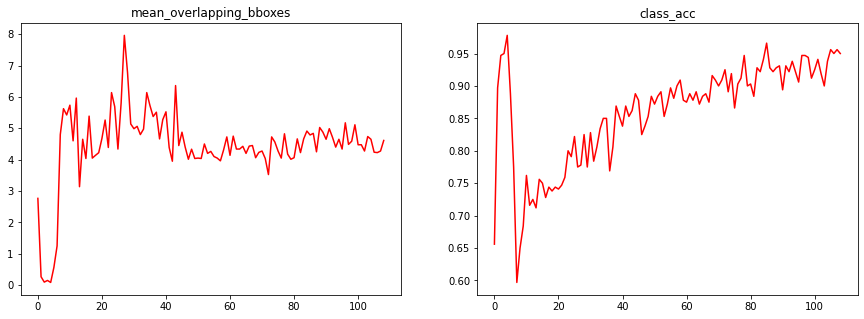

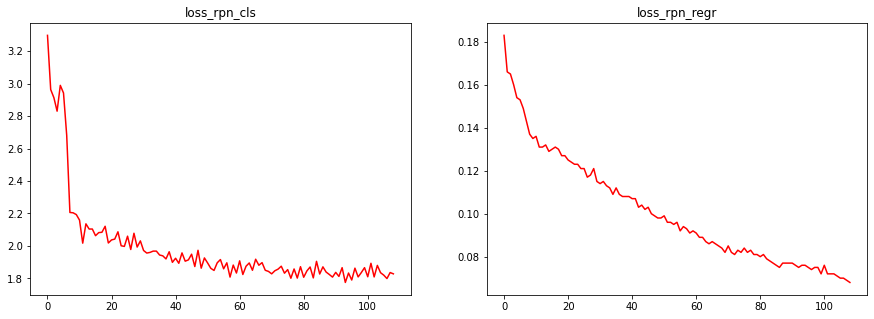

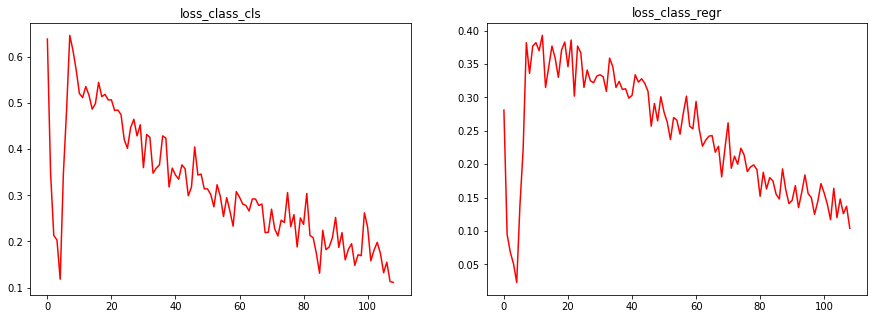

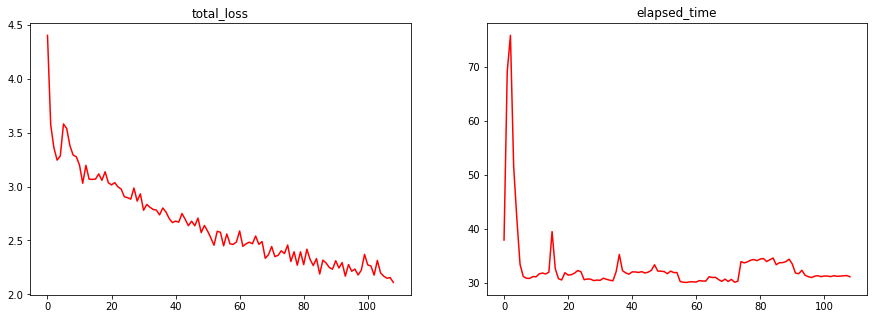

In [39]:
# Load the records
record_df = pd.read_csv(C.record_path)

r_epochs = len(record_df)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['elapsed_time'], 'r')
plt.title('elapsed_time')

plt.show()

# Test

In [0]:
def format_img_size(img, C):
	""" formats the image size based on config """
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
		
	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	return img, ratio	

def format_img_channels(img, C):
	""" formats the image channels based on config """
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

def format_img(img, C):
	""" formats an image for model prediction based on config """
	img, ratio = format_img_size(img, C)
	img = format_img_channels(img, C)
	return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return (real_x1, real_y1, real_x2 ,real_y2)

In [41]:
num_features = 512

input_shape_img = (None, None, 3)
input_shape_features = (None, None, num_features)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (VGG here, can be Resnet50, Inception, etc)
shared_layers = nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(feature_map_input, roi_input, C.num_rois, nb_classes=len(C.class_mapping))

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

Loading weights from /content/drive/My Drive/frcnn/model-lbp5/model_frcnn_vgg.hdf5


In [42]:
# Switch key value for class mapping
class_mapping = C.class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{0: 'N', 1: 'bg'}


In [0]:
test_imgs = os.listdir(test_base_path)

imgs_path = []
for i in range(12):
	idx = np.random.randint(len(test_imgs))
	imgs_path.append(test_imgs[idx])

all_imgs = []

classes = {}

In [0]:
# If the box classification value is less than this, we ignore this box
bbox_threshold = 0.7

for idx, img_name in enumerate(imgs_path):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue
    print(img_name)
    st = time.time()
    filepath = os.path.join(test_base_path, img_name)

    img = cv2.imread(filepath)

    X, ratio = format_img(img, C)
    
    X = np.transpose(X, (0, 2, 3, 1))

    # get output layer Y1, Y2 from the RPN and the feature maps F
    # Y1: y_rpn_cls
    # Y2: y_rpn_regr
    [Y1, Y2, F] = model_rpn.predict(X)

    # Get bboxes by applying NMS 
    # R.shape = (300, 4)
    R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate bboxes coordinates on resized image
        for ii in range(P_cls.shape[1]):
            # Ignore 'bg' class
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            # Calculate real coordinates on original image
            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

            cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),4)

            textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (real_x1, real_y1-0)

            cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 1)
            cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
            cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

    print('Elapsed time = {}'.format(time.time() - st))
    print(all_dets)
    plt.figure(figsize=(10,10))
    plt.grid()
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

Admira-Fusion_008.tif
Elapsed time = 12.82801342010498
[('N', 93.61396431922913), ('N', 83.57371687889099)]


#### Measure mAP

In [0]:
def get_map(pred, gt, f):
	T = {}
	P = {}
	fx, fy = f

	for bbox in gt:
		bbox['bbox_matched'] = False

	pred_probs = np.array([s['prob'] for s in pred])
	box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]

	for box_idx in box_idx_sorted_by_prob:
		pred_box = pred[box_idx]
		pred_class = pred_box['class']
		pred_x1 = pred_box['x1']
		pred_x2 = pred_box['x2']
		pred_y1 = pred_box['y1']
		pred_y2 = pred_box['y2']
		pred_prob = pred_box['prob']
		if pred_class not in P:
			P[pred_class] = []
			T[pred_class] = []
		P[pred_class].append(pred_prob)
		found_match = False

		for gt_box in gt:
			gt_class = gt_box['class']
			gt_x1 = gt_box['x1']/fx
			gt_x2 = gt_box['x2']/fx
			gt_y1 = gt_box['y1']/fy
			gt_y2 = gt_box['y2']/fy
			gt_seen = gt_box['bbox_matched']
			if gt_class != pred_class:
				continue
			if gt_seen:
				continue
			iou_map = iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
			if iou_map >= 0.5:
				found_match = True
				gt_box['bbox_matched'] = True
				break
			else:
				continue

		T[pred_class].append(int(found_match))

	for gt_box in gt:
		if not gt_box['bbox_matched']:# and not gt_box['difficult']:
			if gt_box['class'] not in P:
				P[gt_box['class']] = []
				T[gt_box['class']] = []

			T[gt_box['class']].append(1)
			P[gt_box['class']].append(0)

	#import pdb
	#pdb.set_trace()
	return T, P

In [0]:
def format_img_map(img, C):
	"""Format image for mAP. Resize original image to C.im_size (300 in here)

	Args:
		img: cv2 image
		C: config

	Returns:
		img: Scaled and normalized image with expanding dimension
		fx: ratio for width scaling
		fy: ratio for height scaling
	"""

	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
	
	if width <= height:
		f = img_min_side/width
		new_height = int(f * height)
		new_width = int(img_min_side)
	else:
		f = img_min_side/height
		new_width = int(f * width)
		new_height = int(img_min_side)
	fx = width/float(new_width)
	fy = height/float(new_height)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	# Change image channel from BGR to RGB
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	# Change img shape from (height, width, channel) to (channel, height, width)
	img = np.transpose(img, (2, 0, 1))
	# Expand one dimension at axis 0
	# img shape becames (1, channel, height, width)
	img = np.expand_dims(img, axis=0)
	return img, fx, fy

In [0]:
print(class_mapping)

In [0]:
# This might takes a while to parser the data
test_imgs, _, _ = get_data(test_path)

In [0]:
T = {}
P = {}
mAPs = []
for idx, img_data in enumerate(test_imgs):
    print('{}/{}'.format(idx,len(test_imgs)))
    st = time.time()
    filepath = img_data['filepath']

    img = cv2.imread(filepath)

    X, fx, fy = format_img_map(img, C)

    # Change X (img) shape from (1, channel, height, width) to (1, height, width, channel)
    X = np.transpose(X, (0, 2, 3, 1))

    # get the feature maps and output from the RPN
    [Y1, Y2, F] = model_rpn.predict(X)


    R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0] // C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois * jk:C.num_rois * (jk + 1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0] // C.num_rois:
            # pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0], C.num_rois, curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate all classes' bboxes coordinates on resized image (300, 400)
        # Drop 'bg' classes bboxes
        for ii in range(P_cls.shape[1]):

            # If class name is 'bg', continue
            if np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            # Get class name
            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4 * cls_num:4 * (cls_num + 1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([16 * x, 16 * y, 16 * (x + w), 16 * (y + h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        # Apply non-max-suppression on final bboxes to get the output bounding boxe
        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk, :]
            det = {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': key, 'prob': new_probs[jk]}
            all_dets.append(det)


    print('Elapsed time = {}'.format(time.time() - st))
    t, p = get_map(all_dets, img_data['bboxes'], (fx, fy))
    for key in t.keys():
        if key not in T:
            T[key] = []
            P[key] = []
        T[key].extend(t[key])
        P[key].extend(p[key])
    all_aps = []
    for key in T.keys():
        ap = average_precision_score(T[key], P[key])
        print('{} AP: {}'.format(key, ap))
        all_aps.append(ap)
    print('mAP = {}'.format(np.mean(np.array(all_aps))))
    mAPs.append(np.mean(np.array(all_aps)))
    #print(T)
    #print(P)
    
print()
print('mean average precision:', np.mean(np.array(mAPs)))

In [0]:
mAP = [mAP for mAP in mAPs if str(mAP)!='nan']
mean_average_prec = round(np.mean(np.array(mAP)), 3)
print('After training %dk batches, the mean average precision is %0.3f'%(len(record_df), mean_average_prec))

# record_df.loc[len(record_df)-1, 'mAP'] = mean_average_prec
# record_df.to_csv(C.record_path, index=0)
# print('Save mAP to {}'.format(C.record_path))